The below data was taken from Journal of the Physical Society of Japan **85**, 043705 (2016).

My understanding of their analysis is as follows:
- Measure $C_p$, and fit the low temperature portion of $C_p(4\,\text{T})$ to: $C_p=\gamma_NT+\beta T^3$
- Subtract the phonon ($T^3$) term to get $C_\text{ele}=C_p-\beta T^3$
- In the $0\,\text{T}$  data, there is a $T$-linear term, the "residual electronic heat capacity", $\gamma^*T$ (where $\gamma^*=3.21\,\text{mJK}^{-2}\text{mol}^{-1}$). This term is subtracted from all of the data (not just $0\,\text{T}$) to get $C_\text{sc}=C_\text{ele}-\gamma^*T,$ which is plotted as a function of temperature in Figure 4. 
- **This is the data we were given for several different magnetic fields**

To fit the data, I did the following:
- Load the $0\,\text{T}$ (superconducting) and $4\,\text{T}$ (normal) $C_\text{sc}$ vs. $T$ datasets
- Fit a line $C_\text{sc fit}$ to the clean $4\,\text{T}$ data below about $4\,\text{K}$
- From the $0\,\text{T}$ signal, we want to subtract the normal state electronic "background" specific heat $C_\text{ele}(4\,\text{T})$ to isolate the signal due entirely to superconductivity. But a term $\gamma^*T$ was subtracted from $C_\text{ele}(4\,\text{T})$ to get $C_\text{sc}(4\,\text{T})$, so to calculate $\Delta C(T)$, the change in specific heat due to superconductivity, we need to take
$$\Delta C(T)=C_\text{sc}(0\,\text{T})-C_\text{ele}(4\,\text{T})=C_\text{sc}(0\,\text{T})-[C_\text{sc}(4\,\text{T})+\gamma^*T]\approx C_\text{sc}(0\,\text{T})-[C_\text{sc fit}(4\,\text{T})+\gamma^*T]$$

In [1]:
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy import integrate
from scipy import optimize

import matplotlib.pyplot as plt
%matplotlib inline

df_gap = pd.read_csv('bcsgap.txt', '\t')

In [2]:
def data_load(fileSC, fileNM, plot=True):
    df_sc = pd.read_csv(fileSC, '\t')
    df_nm = pd.read_csv(fileNM, '\t')
    df_sc.columns, df_nm.columns = ['t', 'Csc'], ['t', 'Csc']
    df_sc.sort_values(by='t', inplace=True)
    df_nm.sort_values(by='t', inplace=True)
    df_sc.Csc = 1e-3*df_sc.Csc
    df_nm.Csc = 1e-3*df_nm.Csc
    if plot:
        plt.plot(df_sc.t, df_sc.Csc, 'b.')
        plt.plot(df_nm.t, df_nm.Csc, 'r.')
        plt.xlabel('Temp (K)', fontsize=16)
        plt.ylabel(r'$C_{sc}$', fontsize=16)
        plt.show()
    return df_sc, df_nm

def nm_subtract(df_sc, df_nm, t_ub=4, gam = 0.00321, plot=True):
    line_nm = np.polyfit(df_nm.t[df_nm.t<t_ub], df_nm.Csc[df_nm.t<t_ub], deg=1)
    print(line_nm)
    C_nm_fit = line_nm[0]*df_sc.t+line_nm[1]
    C_sc = df_sc.Csc-(C_nm_fit+gam*df_sc.t)
    if plot:
        plt.plot(df_sc.t, C_sc, '.')
        plt.xlabel('Temp (K)', fontsize=16)
        plt.ylabel(r'$\Delta C$', fontsize=16)
        plt.show()
    return C_sc

def delta_interp(df_gap, temp):
    tck = interpolate.splrep(df_gap.t, df_gap.gap)
    gap = interpolate.splev(temp, tck, der=0)
    return gap

def inner_integrand(emin, emax, d, phi, alpha, t):
    return integrate.fixed_quad(integrand_Ses, emin, emax, args=(d, alpha, phi, t), n=20)[0]

def outer_integrand(phi, emin, emax, d, alpha, t):
    return inner_integrand(emin, emax, d, phi, alpha, t)

def integrand_Ses(e, delta, alpha, phi, t):
    E = np.sqrt(e**2 + (delta*np.cos(2*phi))**2)
    f = 1/(np.longdouble(np.exp(E*alpha/t)+1))
    return f*(E+e**2/E)

def Ses_fit(temp, alpha, df_gap, emin=0, emax=50, wave='s'):
    const = 6*alpha**2/np.pi**2
    N = len(temp)
    Ses = np.zeros(N)
    delta = delta_interp(df_gap, temp)
    for i in range(N):
        t = temp[i]
        d = delta[i]
        if wave.lower() == 's':
            # s-wave
            Ses[i] = (1/t)*integrate.fixed_quad(integrand_Ses, emin, emax, args=(d, alpha, 0, t), n=20)[0]
        else:
            # d-wave
            Ses[i] = (1/(t*2*np.pi))*integrate.fixed_quad(outer_integrand, 0, 2*np.pi,
               args=(emin, emax, d, alpha, t), n=20)[0]            
    Ses *= const
    return np.array([temp, Ses])

def deltaC(t, alpha, gamma, Tc, df_gap, wave):
    t /= Tc
    Ses = Ses_fit(t, alpha, df_gap, wave=wave)
    dC = np.zeros(len(t))
    dt = np.gradient(t)
    dS = np.gradient(Ses[1])
    dSdt = dS/dt
    for i in range(len(t)):
        dC[i] = t[i]*(dSdt[i]-1)
    return gamma*Tc*dC

def C_residuals(alpha_gamma_Tc, temp, df_gap, C_exp, wave):
    alpha, gamma, Tc = alpha_gamma_Tc
    return deltaC(np.array(temp), alpha, gamma, Tc, df_gap, wave)-np.array(C_exp)

def C_leastsq(alpha_gamma_Tc_guess, temp, C_exp, df_gap, wave='s', plot=True):
    """Returns optimal [alpha, gamma, Tc]
    """
    popt = optimize.leastsq(C_residuals, alpha_gamma_Tc_guess, args=(temp, df_gap, C_exp, wave),
                            full_output=1, xtol=1e-11, maxfev=2000)
    ss_err = (popt[2]['fvec']**2).sum()
    ss_tot=((C_exp-C_exp.mean())**2).sum()
    pcov = popt[1]
    if pcov is not None:
        pcov *= ss_err/(len(C_exp)-len(alpha_gamma_Tc_guess))
    else:
        pcov = np.inf
    error = [] 
    for i in range(len(popt[0])):
        try:
          error.append(np.absolute(pcov[i][i])**0.5)
        except:
          error.append( 0.00 )
    error = np.array(error)
    print(wave+'-wave fit:\n')
    print('[alpha  gamma  Tc]\n[std deviations]')
    print(popt[0])
    print(error)
    print('\nTotal squared error: {}'.format(ss_err))
    print('r-squared: {}'.format(1-ss_err/ss_tot))
    if plot:
        alpha, gamma, Tc = popt[0]
        dC = deltaC(Tc*np.linspace(0,1,100), alpha, gamma, Tc, df_gap, wave=wave)
        plt.plot(temp, C_exp, '.')
        plt.plot(Tc*np.linspace(0,1,100), dC, 'r-', lw=2)
        plt.xlabel('Temp (K)', fontsize=16)
        plt.ylabel(r'$\Delta C$', fontsize=16)
        plt.show()
    return popt, error

def predict_Hp(popt, gg=1):
    alpha, Tc = popt[0][0], popt[0][2]
    kb = 1.38064852e-23
    ub = 9.27400999e-24
    return gg*alpha*kb*Tc/(np.sqrt(2)*ub)

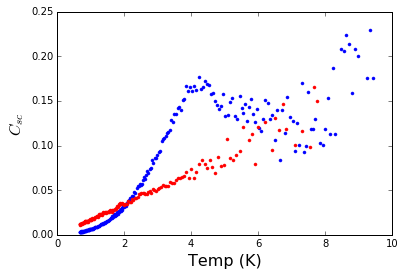

In [3]:
file_sc = r'./bets_jpsj_0T.txt'
file_nm = r'./bets_jpsj_4T.txt'
df_0t, df_4t = data_load(file_sc, file_nm)

[  1.74073169e-02   1.41735266e-05]


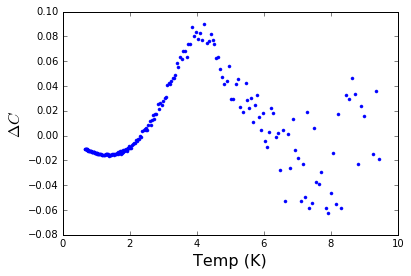

In [4]:
C_sc = nm_subtract(df_0t, df_4t)

### $s$- and $d$-wave fits
------------

s-wave fit:

[alpha  gamma  Tc]
[std deviations]
[ 1.90070102  0.01536623  4.26164665]
[ 0.02097138  0.00033224  0.02254259]

Total squared error: 0.0008268445001013337
r-squared: 0.9928511486618937


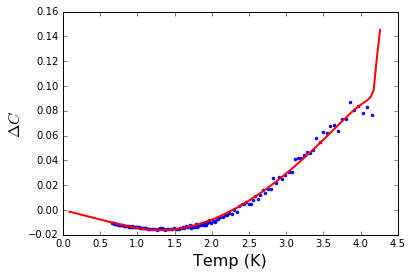

d-wave fit:

[alpha  gamma  Tc]
[std deviations]
[ 1.98144709  0.01500983  4.25403508]
[ 0.01840712  0.00027637  0.02013127]

Total squared error: 0.0006416516035220702
r-squared: 0.9944523160958625


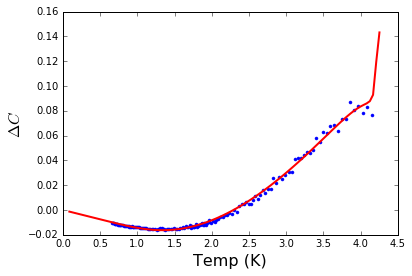

In [5]:
t = df_0t.t[:df_0t.Csc[df_0t.t<6].argmax()].values # fit data below the peak
C = C_sc[:df_0t.Csc[df_0t.t<6].argmax()]
p0 = [1.0, 0.02, 5.0] # inital guess for [alpha, gamma, Tc]
popt_s, err_s = C_leastsq(p0, t, C, df_gap, wave='s')
popt_d, err_d = C_leastsq(p0, t, C, df_gap, wave='d')

In [6]:
print('Predicted Hp based on s-wave fit: {:.6} tesla'.format(predict_Hp(popt_s)))
print('Predicted Hp based on d-wave fit: {:.6} tesla'.format(predict_Hp(popt_d)))

Predicted Hp based on s-wave fit: 8.52691 tesla
Predicted Hp based on d-wave fit: 8.87328 tesla
